# MNIST classification using Keras and TensorBoard

In [26]:
from IPython.display import display, Markdown
with open('setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Define the following env variable before starting Jupyter Lab:  
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=you_region`  
  
Start Jupyter Lab:  
`jupyter lab`  
  
Choose the proper Anaconda python environment:  
`Python [conda env:env_tensorflow]`  
    

## Import packages

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.backend.event_processing import event_accumulator
from absl import logging
from datetime import datetime
import os
import shutil
import numpy as np

In [3]:
tf.version.VERSION

'2.1.0'

## Define paths

In [4]:
try:
    data_dir=os.environ['PATH_DATASETS']
except:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except:
    print('missing PATH_TENSORBOARD')

## Define input function

In [5]:
logging.set_verbosity(logging.INFO)

In [6]:
STEPS_PER_EPOCH = 5
BATCH_SIZE = 64
NUM_EPOCHS = 5

In [7]:
def input_fn():
    datasets, ds_info = tfds.load(name='mnist', with_info=True, as_supervised=True,data_dir=data_dir)
    mnist_train, mnist_test = datasets['train'], datasets['test']

    BUFFER_SIZE = 10000
    BATCH_SIZE = 64

    def scale(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
    
        return image, label[..., tf.newaxis]

    train_data = mnist_train.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_data.repeat()

## Build a model

In [8]:
def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02),
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [9]:
model = make_model()

optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, epsilon=1e-07)

model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                346176    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

## Setup TensoBoard

In [11]:
for i in os.listdir(tensorboard_dir):
    if os.path.isdir(tensorboard_dir+'/'+i):
        print(i)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tensorboard'

In [14]:
# clean old TensorBoard directory 
for i in os.listdir(tensorboard_dir):
        if os.path.isdir(tensorboard_dir+'/'+i):
            print(i)
            shutil.rmtree(tensorboard_dir+'/'+i, ignore_errors=False)

20200207-141800


In [15]:
log_dir=tensorboard_dir+'/'+datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      profile_batch = 
                                                      3,write_graph=True)

In [16]:
log_dir

'/tmp/tensorboard/20200207-142619'

In [17]:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard  --logdir   {log_dir}

## Train the model

In [18]:
model.fit(input_fn(),
          steps_per_epoch=5,
          epochs=10,
          callbacks=[tensorboard_callback],
          verbose =1)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/Users/tarrade/tensorflow_datasets/mnist/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /Users/tarrade/tensorflow_datasets/mnist/3.0.0


Train for 5 steps
Epoch 1/10
5/5 [==============================] - 2s 349ms/step - loss: 1.4719 - accuracy: 0.5625
Epoch 2/10
5/5 [==============================] - 0s 26ms/step - loss: 0.6919 - accuracy: 0.8188
Epoch 3/10
5/5 [==============================] - 0s 29ms/step - loss: 0.5870 - accuracy: 0.8375
Epoch 4/10
5/5 [==============================] - 0s 20ms/step - loss: 0.5472 - accuracy: 0.8375
Epoch 5/10
5/5 [==============================] - 0s 20ms/step - loss: 0.4538 - accuracy: 0.8719
Epoch 6/10
5/5 [==============================] - 0s 22ms/step - loss: 0.3270 - accuracy: 0.9156
Epoch 7/10
5/5 [==============================] - 0s 21ms/step - loss: 0.3053 - accuracy: 0.9094
Epoch 8/10
5/5 [==============================] - 0s 20ms/step - loss: 0.2971 - accuracy: 0.9156
Epoch 9/10
5/5 [==============================] - 0s 20ms/step - loss: 0.2878 - accuracy: 0.9187
Epoch 10/10
5/5 [==============================] - 0s 25ms/step - loss: 0.2393 - accuracy: 0.9469


## Explore output files from TensorBoard

In [19]:
def load_data_tensorboard(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []
        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)
        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [20]:
print('let inspect events.out.tfevents.* files')
history_train=load_data_tensorboard(log_dir+'/train')

let inspect events.out.tfevents.* files


In [21]:
history_train

{'epoch_accuracy': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  array([0.5625    , 0.81875002, 0.83749998, 0.83749998, 0.87187499,
         0.91562498, 0.90937501, 0.91562498, 0.91874999, 0.94687498])),
 'epoch_loss': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  array([1.47189271, 0.69193679, 0.58703375, 0.54716879, 0.45381948,
         0.3270458 , 0.30532584, 0.29714108, 0.28784838, 0.23934013]))}

In [22]:
print(history_train.keys())

dict_keys(['epoch_accuracy', 'epoch_loss'])


Loss:
  - loss [training dataset]: 0.239

Accuracy:
  - accuracy [training dataset]: 94.69%


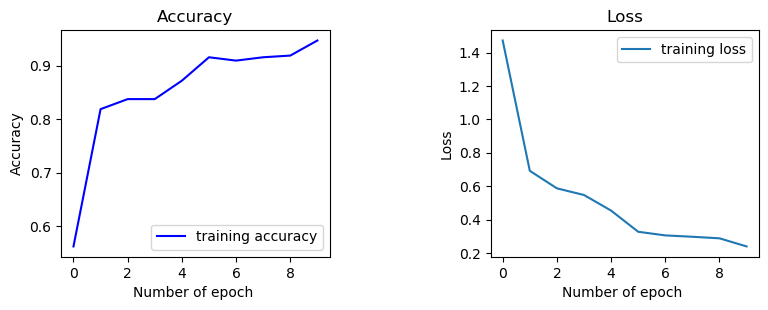

In [23]:
ml_utils.plot_acc_loss(history_train['epoch_loss'][0],history_train['epoch_loss'][1],
                       history_train['epoch_accuracy'][0],history_train['epoch_accuracy'][1])